# Application program interface - API

# Introduction to LSTMs: Making Stock Movement Predictions Far into the Future

## Long Short-Term Memory models are extremely powerful time-series models.

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
import mysql.connector

In [5]:
conn = mysql.connector.connect(user='foouser',password='F88Pa%%**',host='134.209.144.239',database='stocksdb')
print(conn)

## Open: Opening stock price of the day
## Close: Closing stock price of the day
## High: Highest stock price of the data
## Low: Lowest stock price of the day

In [6]:
cursor = conn.cursor()

In [7]:
cursor.execute("show tables")
print(cursor.fetchall())

[('interview',)]


In [8]:
lt=pd.read_sql_query("""SELECT * from interview """,conn)

In [9]:
#lt.to_csv('stock.csv')

In [18]:
df=pd.read_csv('stock.csv')

C:\Users\VADNALA PRASHANTH\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
df.head()

,Unnamed: 0,isin,insertion_datetime,datetime,open,high,low,close,volume,open_interest,Date,time
0,0,INE545A01016,NaN,1/1/2018 9:15,2419.0,2436.00,2408.90,2435.25,10281,NaN,1/1/2018,9:15
1,1,INE545A01016,NaN,1/1/2018 9:16,2435.0,2440.00,2426.45,2439.00,13315,NaN,1/1/2018,9:16
2,2,INE545A01016,NaN,1/1/2018 9:17,2439.7,2439.70,2422.10,2424.95,3760,NaN,1/1/2018,9:17
3,3,INE545A01016,NaN,1/1/2018 9:18,2420.0,2424.50,2386.50,2395.00,11653,NaN,1/1/2018,9:18
4,4,INE545A01016,NaN,1/1/2018 9:19,2395.0,2413.95,2394.70,2409.85,7744,NaN,1/1/2018,9:19


In [20]:
df.shape

(500000, 12)

In [21]:
df.isnull().sum()

Unnamed: 0                 0
isin                       0
insertion_datetime    451940
datetime                   0
open                       0
high                       0
low                        0
close                      0
volume                     0
open_interest         451940
Date                       0
time                       0
dtype: int64

In [22]:
df.insertion_datetime.unique()

array([nan, '1/23/2019 17:10'], dtype=object)

In [23]:
df.open_interest.nunique()

4214

In [24]:
df.dtypes

Unnamed: 0              int64
isin                   object
insertion_datetime     object
datetime               object
open                  float64
high                  float64
low                   float64
close                 float64
volume                  int64
open_interest         float64
Date                   object
time                   object
dtype: object

In [25]:
import datetime as dt

In [26]:
import os

In [27]:
os.getcwd()

'C:\\Users\\VADNALA PRASHANTH\\Downloads\\DATA SCIENCE'

In [29]:
df.drop(['Unnamed: 0','datetime','insertion_datetime'], axis = 1, inplace = True)

In [30]:
df.head()

,isin,open,high,low,close,volume,open_interest,Date,time
0,INE545A01016,2419.0,2436.00,2408.90,2435.25,10281,NaN,1/1/2018,9:15
1,INE545A01016,2435.0,2440.00,2426.45,2439.00,13315,NaN,1/1/2018,9:16
2,INE545A01016,2439.7,2439.70,2422.10,2424.95,3760,NaN,1/1/2018,9:17
3,INE545A01016,2420.0,2424.50,2386.50,2395.00,11653,NaN,1/1/2018,9:18
4,INE545A01016,2395.0,2413.95,2394.70,2409.85,7744,NaN,1/1/2018,9:19


In [31]:
df = df.sort_values('Date')

In [32]:
df.head()

,isin,open,high,low,close,volume,open_interest,Date,time
0,INE545A01016,2419.00,2436.00,2408.90,2435.25,10281,NaN,1/1/2018,9:15
455245,INE492A01029,590.05,590.60,590.05,590.60,1,NaN,1/1/2018,11:15
455244,INE492A01029,590.05,590.05,590.05,590.05,0,NaN,1/1/2018,11:14
455243,INE492A01029,590.05,590.05,590.05,590.05,2,NaN,1/1/2018,11:13
455242,INE492A01029,591.70,591.70,590.05,590.05,100,NaN,1/1/2018,11:12


In [40]:
high_prices = df.loc[:,'high'].as_matrix()
low_prices = df.loc[:,'low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

C:\Users\VADNALA PRASHANTH\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\VADNALA PRASHANTH\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [45]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

In [46]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [47]:
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [48]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [49]:
EMA = 0.0
gamma = 0.1
for ti in range(11000):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [51]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']
        
        std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
        mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
        std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.02183


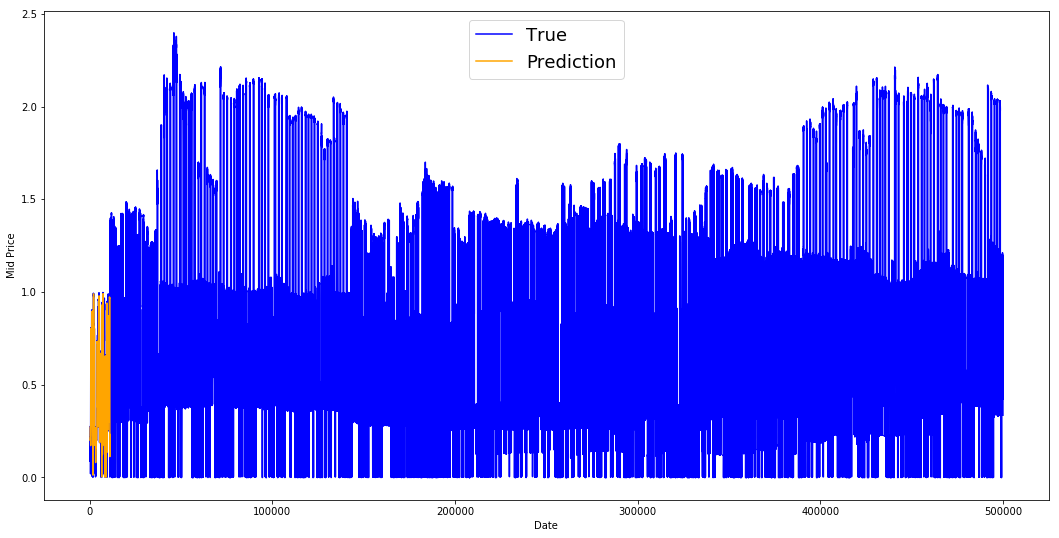

In [52]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [53]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5
for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00028


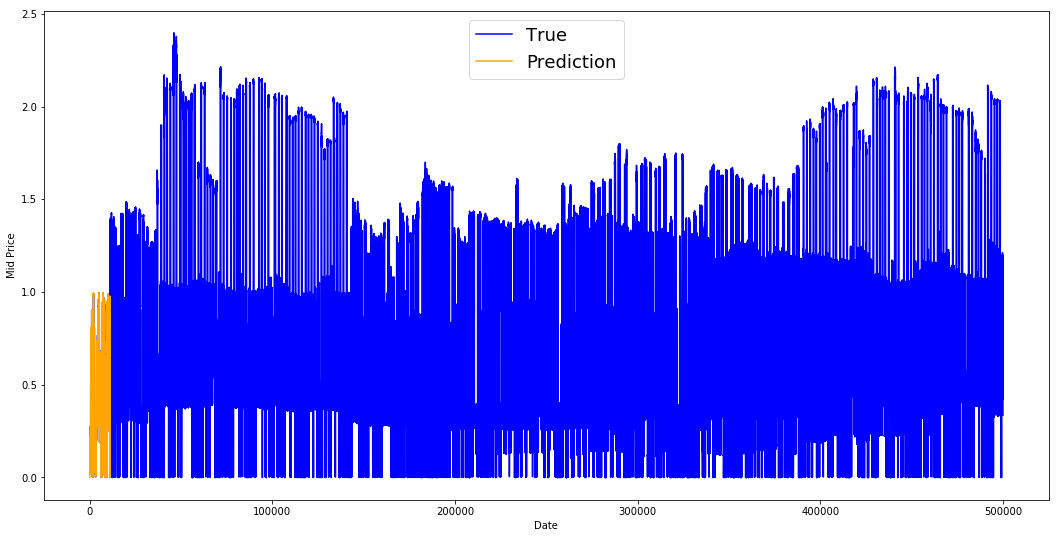

In [54]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [55]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
         for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)
return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()
for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)